## CuffDiff Summary
### Author: Xiang Li



In [1]:
import numpy as np
import pandas as pd
import os

In [4]:
# For any input of /gene_exp.diff, return its All genes with
### gene_id, cond1, cond2, log2(fold_change), p_value, plus a number of order.
def generate_All_Genes(Input_Path, number):
#### READ FILE
    df = pd.read_csv(Input_Path+'/gene_exp.diff', sep='\t', header=0, usecols={'test_id',\
    'status','sample_1','sample_2','value_1','value_2','log2(fold_change)','p_value','q_value'})
#### Rename columns
    df=df.rename(columns={'test_id':'gene_id', 'value_1': df['sample_1'].unique()[0], 'value_2': df['sample_2'].unique()[0]})
#### Output   
    return df.loc[:,['gene_id',df['sample_1'].unique()[0],df['sample_2'].unique()[0],'log2(fold_change)',
                     'p_value','q_value', 'End_'+str(number), '||']].fillna('')
####################################################################################


### For any input of /gene_exp.diff, return its up_DEGs genes with
### gene_id, cond1, cond2, log2(fold_change), p_value, plus a number of order.
### Parameters for DEGs:
FC_UP=1.5
q_value_less=0.05
FPKM_threshold=1.0
####################################################################################

def generate_Upregulated_Genes(Input_Path):
#### READ FILE
    df = pd.read_csv(Input_Path+'/gene_exp.diff', sep='\t', header=0, usecols={'test_id',\
    'status','sample_1','sample_2', 'value_1','value_2','log2(fold_change)','p_value','q_value'})
#### Filter
    df=df[(df['status']=='OK') & (df['q_value']<=q_value_less) & (df['value_2']>=FPKM_threshold) & (df['log2(fold_change)'] >= np.log2(FC_UP))]
#### Rearrange Columns
    df=df.rename(columns={'test_id':'gene_id','value_1': df['sample_1'].unique()[0], 'value_2': df['sample_2'].unique()[0]})
#### Output
    return df.loc[:,['gene_id', df['sample_1'].unique()[0],df['sample_2'].unique()[0],'log2(fold_change)','p_value','q_value']]
####################################################################################

def generate_Downregulated_Genes(Input_Path):
#### READ FILE FROM CuffDiff Results
    df = pd.read_csv(Input_Path+'/gene_exp.diff', sep='\t', header=0, usecols={'test_id',\
    'status','sample_1','sample_2', 'value_1','value_2','log2(fold_change)','p_value','q_value'})
#### Filter
    df=df[(df['status']=='OK') & (df['q_value']<=q_value_less) & (df['value_1']>=FPKM_threshold) & (df['log2(fold_change)']<= -np.log2(FC_UP))]   
#### Rearrange Columns
    df=df.rename(columns={'test_id':'gene_id','value_1': df['sample_1'].unique()[0], 'value_2': df['sample_2'].unique()[0]})
#### Output
    return df.loc[:,['gene_id', df['sample_1'].unique()[0],df['sample_2'].unique()[0],'log2(fold_change)','p_value','q_value']]


#### Functions to read /genes.read_group_tracking and output FPKM
def generate_genes_FPKM_df(Input_Path):
    df = pd.read_csv(INPUT_PATH+'/genes.read_group_tracking', sep='\t', header=0)
    FPKM_df = None
    for cond in df['condition'].unique():
        for replica in df[df['condition'] == cond]['replicate'].unique():
            #print (cond, replica)
            temp_df = (df[ (df['condition'] == cond) & (df['replicate'] == replica)].loc[:,['tracking_id', 'FPKM']])
            cond_name= cond+'_'+str(replica)
            temp_df.rename(columns={'tracking_id': 'gene_id', 'FPKM': cond_name }, inplace=True)
            if FPKM_df is None:
                FPKM_df
                FPKM_df = temp_df  
            else:
                FPKM_df = FPKM_df.merge(temp_df, on='gene_id', how='outer', suffixes=('','_'))
    return FPKM_df

def Add_common_header(df,common_header):
    name_list=[common_header]*len(df.columns)
    tuples = list(zip(name_list,df.columns))
    df.columns = pd.MultiIndex.from_tuples(tuples)
    return df


def DIR_CHECK_CREATE(Input_Path):
    if (not os.path.isdir(Input_Path)):
        print ("Dir check and create is" + Input_Path)
        os.mkdir(Input_Path)
    else: print ('Input_Path exists')

## Generate Excel file contains all genes, and DEGs. 

In [14]:
PATH_FOLDER=os.getcwd()+ '/CuffDiff_Results/'
OUT_FOLDER=os.getcwd()+'/genelist/'

DIR_CHECK_CREATE(PATH_FOLDER)
DIR_CHECK_CREATE(OUT_FOLDER)


INPUT_LIST=os.listdir(PATH_FOLDER)
writer = pd.ExcelWriter(OUT_FOLDER+'CD8-HP_CuffDiff_Summary201806.xlsx', engine='xlsxwriter')

i=0
for input_name in INPUT_LIST[:]:
    INPUT_PATH = PATH_FOLDER+input_name
    if (i==0):
        df_all=generate_genes_FPKM_df(INPUT_PATH)
        df_all[input_name]=''
        df_all = df_all.merge(generate_All_Genes(INPUT_PATH,i+1), on='gene_id', how='inner', suffixes=('','_')) 
        i+=1
        continue
    df_all = df_all.merge(generate_genes_FPKM_df(INPUT_PATH), on='gene_id', how='inner', suffixes=('','_'))
    df_all[input_name]=''
    df_all = df_all.merge(generate_All_Genes(INPUT_PATH,i+1), on='gene_id', how='inner', suffixes=('','_')) 
    
    i+=1
df_all.to_excel(writer, sheet_name='All_Genes', index=None)



###### Generating a DEGs list in the last.
DEGs_List=pd.DataFrame([],columns=['gene_id'])


for input_name in INPUT_LIST:
    INPUT_PATH = PATH_FOLDER+input_name
    print ('Library:' + input_name)
    df_up = generate_genes_FPKM_df(INPUT_PATH)
    df_up[input_name]=''
    df_up = df_up.merge(generate_Upregulated_Genes(INPUT_PATH), on='gene_id', how='inner', suffixes=('','_'))
    df_up.to_excel( writer, sheet_name='up_'+input_name, index=None)
    
    DEGs_List=pd.concat([DEGs_List,df_up[['gene_id']]])
    print ('# of Up:' )
    print(df_up.shape)
    
    df_down = generate_genes_FPKM_df(INPUT_PATH)
    df_down[input_name]=''
    df_down = df_down.merge(generate_Downregulated_Genes(INPUT_PATH), on='gene_id', how='inner', suffixes=('','_')) 
    df_down.to_excel( writer, sheet_name='down_'+input_name,index=None)
    DEGs_List=pd.concat([DEGs_List,df_down[['gene_id']]])
    print ('# of Down')
    print(df_down.shape)
    print ('')

print ("Total Number of DEGs is:" + str(len(DEGs_List['gene_id'].unique())))

DEGs_List = pd.DataFrame( list(DEGs_List['gene_id'].unique()), columns=['gene_id'])
DEGs_List.to_excel( writer, sheet_name='Union_DGEs_List',index=None)

writer.save()

Input_Path exists
Input_Path exists
Library:DKO_0h_vs_Ctrl_34n_ref
# of Up:
(1601, 12)
# of Down
(1575, 12)

Library:DKO_0h_vs_WT_0h
# of Up:
(647, 13)
# of Down
(704, 13)

Library:DKO_72h_vs_DKO_0h
# of Up:
(1457, 13)
# of Down
(1025, 13)

Library:DKO_72h_vs_WT_72h
# of Up:
(441, 13)
# of Down
(749, 13)

Library:WT_72h_vs_WT_0h
# of Up:
(1812, 13)
# of Down
(1272, 13)

Total Number of DEGs is:5623


### Test output Results

In [25]:
df_all=generate_genes_FPKM_df(INPUT_PATH)
df_down = generate_genes_FPKM_df(INPUT_PATH)
df_down[df_down['gene_id']=='Rnaset2a,Rnaset2b']

,gene_id,WT_0h_0,WT_0h_1,WT_0h_2,WT_72h_0,WT_72h_1,WT_72h_2


# Find Intersection and oneside only.


In [ ]:
#### Detail see Data Clean
PATH_FOLDER=os.getcwd()
INPUT_LIST= ['DKO_CD8_0h_1_2_4n_vs_Ctrl_3n_4n', 'DKO_0h_vs_WT_0h']

INPUT_PATH = PATH_FOLDER+'/genelist/all_libs/down_'+INPUT_LIST[0] +'.bed'

genelist1 = pd.read_csv(INPUT_PATH,sep='\t')
genelist1=genelist1.set_index('gene_id')

INPUT_PATH = PATH_FOLDER+'/genelist/all_libs/down_'+INPUT_LIST[1] +'.bed'
genelist2 = pd.read_csv(INPUT_PATH,sep='\t')
genelist2 = genelist2.set_index('gene_id')
genelist2

#genelist1.index.intersection(genelist2.index)

genelist2.index.intersection(genelist1.index)
#idx1.intersection(idx2)
genelist1.iloc[:,[0,1]]
genelist2.iloc[:,[0,1]]


#### Union
genelist_all = genelist1.iloc[:,[0,1]].merge(genelist2.iloc[:,[0,1]],
how='outer',left_index=True, right_index=True)

print(genelist_all.shape)


#### intersection
intersection_genelists = pd.DataFrame(index=genelist_all.index)
intersection_genelists = intersection_genelists.merge ( genelist1.iloc[:,[0,1]],how='inner',left_index=True, right_index=True)
intersection_genelists = intersection_genelists.merge ( genelist2.iloc[:,[0,1]],how='inner',left_index=True, right_index=True)

print(intersection_genelists.shape)
intersection_genelists.to_csv(os.getcwd()+'/genelist/Overlap_up_genes_'+ '.bed', columns=[],sep='\t')


#### ALL DEGs Generating

In [7]:
[INPUT_LIST[1],INPUT_LIST[3]]

['DKO_0h_vs_WT_0h', 'DKO_72h_vs_WT_72h']

In [12]:
####Generating  FPKM of all DEGs replicates
DIR_CHECK_CREATE(os.getcwd()+'/genelist/')
PATH_FOLDER=os.getcwd()+ '/CuffDiff_Results/'
INPUT_LIST=os.listdir(PATH_FOLDER)

DEGs_INPUT_LIST=[INPUT_LIST[1],INPUT_LIST[3]]
DEGs_INPUT_LIST=INPUT_LIST

#DEGs_List
df_ALL_DEGs=DEGs_List

for input_name in DEGs_INPUT_LIST:
    INPUT_PATH = PATH_FOLDER+input_name
    print ('Library:' + input_name)
    df_ALL_DEGs = df_ALL_DEGs.merge(generate_genes_FPKM_df(INPUT_PATH), on='gene_id',how='inner')



print ('# of DEGs:' )
print(df_ALL_DEGs.shape)
df_ALL_DEGs=df_ALL_DEGs.set_index('gene_id')


Input_Path exists
Library:DKO_0h_vs_Ctrl_34n_ref
Library:DKO_0h_vs_WT_0h
Library:DKO_72h_vs_DKO_0h
Library:DKO_72h_vs_WT_72h
Library:WT_72h_vs_WT_0h
# of DEGs:
(5623, 30)


## From above we can continue using:
# "df_ALL_DEGs" for plot

# Plot Part

In [13]:
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white") 

# display plots in this notebook
%matplotlib inline

# heatmap

(5623, 29)

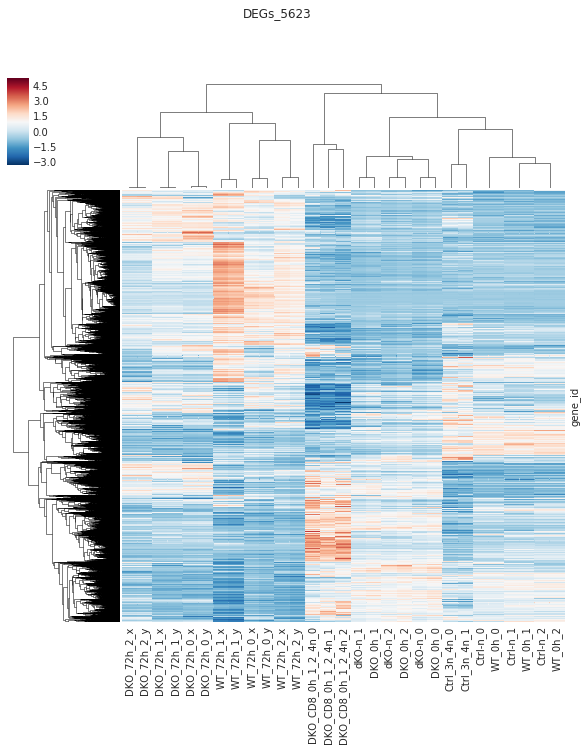

In [15]:
### Drop all zeros rows for plot
Heatmap_Df = df_ALL_DEGs.loc[(df_ALL_DEGs!=0).any(axis=1)]

Heatmap_Name='DEGs_'+str(len(Heatmap_Df.index))
#### Very Important

#Heatmap_Df=FPKM_df.fillna(0)

fig_1 = sns.clustermap(Heatmap_Df,  yticklabels=False, z_score=0, col_cluster=True, cmap='RdBu_r' )
fig_1.savefig(Heatmap_Name+'.png')
fig_1.fig.suptitle(Heatmap_Name)
Heatmap_Df.shape

# PCA



## Input a DataFrame then plot.

In [16]:
# PCA
df_2 = df_ALL_DEGs #.reset_index()

#### Remove unicode of list in python 
df2_gene_id = [x.encode('ascii', 'ignore') for x in df_2.index]


from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

#### In here we set targets as the name of columns, which means our purpose is to compare \
#### the relationship between different columns.
targets= [x.encode('ascii', 'ignore') for x in df_2.columns]

colors=[]
for i in range(len(targets)):
    colors.append( "C"+ str(i))
    #print(colors[i])

################################################################################

df_2_T = df_2.transpose()

# Separating out the features
x = df_2_T.loc[ :, df2_gene_id ].values


# Separating out the target
y = df_2_T.loc[targets,:].values


# Standardizing the featuresbio
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


########### THIS is fucking killing me. reindex df with df2, just using following command.
principalDf.index = df_2_T.index

#finalDf = pd.concat( [principalDf, df_2_T.loc['target']], axis = 1)
principalDf

,principal component 1,principal component 2
Ctrl_3n_4n_0,-9.611481,-60.351322
Ctrl_3n_4n_1,-8.146160,-57.424568
DKO_CD8_0h_1_2_4n_0,-59.608932,67.053024
DKO_CD8_0h_1_2_4n_1,-64.376341,54.908210
DKO_CD8_0h_1_2_4n_2,-72.795119,55.085117
Ctrl-n_0,-27.296778,-46.508727
Ctrl-n_1,-31.645623,-41.528416
Ctrl-n_2,-32.462886,-41.049033
dKO-n_2,-46.108241,7.843257
dKO-n_0,-47.306553,11.530231


(5623, 29)

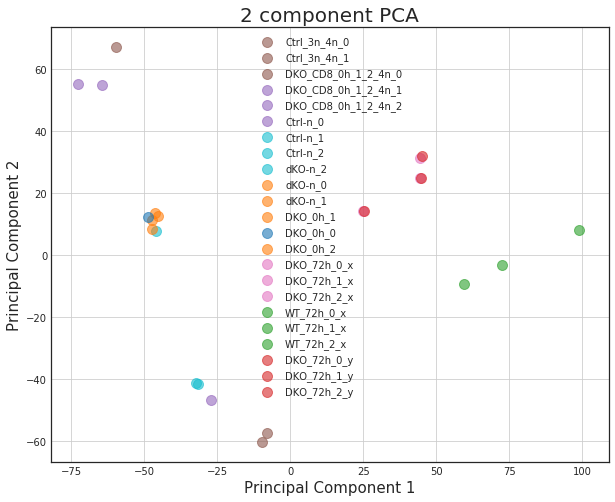

In [17]:
### PLOT

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

colors = ['C5','C5','C5',
          'C4','C4','C4',
          'C9','C9','C9',
          'C1','C1','C1',
          'C0','C1', 
          'C6','C6','C6',
          'C2','C2','C2',
          'C3','C3','C3']

for target, color in zip( targets,colors):
    indicesToKeep = principalDf.index == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , s = 100, c=color, alpha=0.6)
ax.legend(targets)
#ax.set_xlim(-2,8)
ax.grid()
Parameters_Detail='CD8_HP'
fig.savefig('PCA'+Parameters_Detail+'.png')
df_ALL_DEGs.shape